<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Maximum inner product



# Import modules
<hr style = "border:2px solid black" ></hr>

In [ ]:
import os
import time
import hnswlib
import numpy as np
import pandas as pd
from subprocess import call
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking

# Maximum Inner Product
<hr style = "border:2px solid black" ></hr>


- **Matrix factorization** are potent techniques in solving the collaborative filtering problem. It mainly involves building up the user-item interaction matrix, then decomposing it into a user latent factor (a.k.a embedding) and item latent factor each with some user specified dimension (a hyperparameter that we get to tweak).

- To generate the items recommended for each user, we would perform a dot product between the two matrices and retrieve the top-k items that have the highest "scores". 

- This process, however, can often times becomes a large bottleneck for these type of algorithms when the number of users and items becomes fairly large. As exhaustive computation of the dot product is extremely expensive. 

- This document's focus is to demonstrate a order preserving transformation that converts the maximum inner product into a nearest neighborhood search problem to significantly speed up the process for generating the top-k recommendations.
    


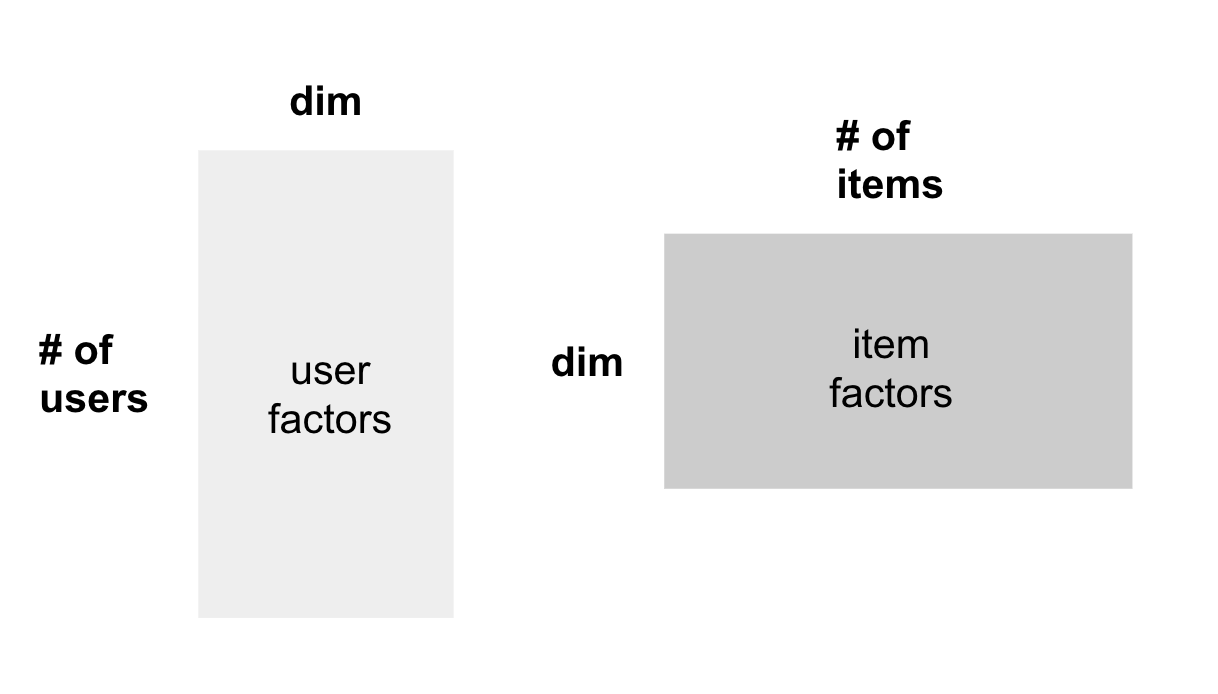

## Order Preserving Transformations

We'll first describe the notation we'll be using. Lower case is for scalars, $x$, bold lower case for vectors, $\mathbf{x}$, and bold upper case for matrices, $\mathbf{X}$.

Given a vector, $\mathbf{x}$. The norm is denoted by $\Vert \mathbf{x} \Vert = \sqrt{\sum^d_{i=1} x_i^2}$. The inner product is represented as $\mathbf{x} \cdot \mathbf{y}$. Last but not least, $(a, \mathbf{x}^T)^T$ is for denoting a concatenation of a scalar $a$ with a vector $\mathbf{x}$.

On one hand, we have a matrix of $n$ vectors $\mathbf{Y} = [\mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_n]$, such that $\mathbf{y}_i \in \mathbb{R}^d$. Where $d$ is the number of dimensions we set for the latent factor. Whereas, our query vector $\mathbf{x} \in \mathbb{R}^d$.

Our objective is to retrieve an index according to the maximum inner product.

$$
\begin{align}
f(\mathbf{Y}, \mathbf{x}) = \underset{i}{\text{argmax}} \space \mathbf{x} \cdot \mathbf{y}_i
\end{align}
$$

The idea behind speeding up the workload for maximum inner product operations is to transform the problem into a distance minimization problem or nearest neighborhood search.

\begin{align}
f(\mathbf{Y}, \mathbf{x}) = \underset{i}{\text{argmin}} \space {\Vert \mathbf{x} - \mathbf{y}_i \Vert}^2
\end{align}

Once we transform the problem into a euclidean distance problem, there are plethora of algorithms/packages available for doing fast similarity search. To do so, we are going to apply a transformation function on our matrix, $\mathbf{Y}$and our query vector, $\mathbf{x}$. Note that the idea here is only to perform transformation on top of the existing $\mathbf{x}$ and $\mathbf{y}$, not to design a whole new algorithm in itself to learn embeddings/latent factors that directly uses distance minimization to generate the prediction, as this prevents us from using the existing matrix factorization algorithms.

The order transformation is to add an additional dimension to each of the latent factors:

\begin{align}
\mathbf{y}_i^* &= \big(\sqrt{\phi^2 - {\Vert \mathbf{y_i} \Vert}^2 }, \mathbf{y_i}^T\big)^T, \text{where } \phi = \underset{i}{\text{max}} \Vert \mathbf{y}_i \Vert \\
\mathbf{x}^* &= (0, \mathbf{x}^T)^T
\end{align}

As

\begin{align}
{\Vert \mathbf{x}^* \Vert}^2 &= {\Vert \mathbf{x} \Vert}^2 \\
{\Vert \mathbf{y}_i^* \Vert}^2 &= \phi^2 - {\Vert \mathbf{y}_i \Vert}^2 + {\Vert \mathbf{y}_i \Vert}^2 = \phi^2 \\
\mathbf{x}^* \cdot \mathbf{y}^*_i &= \sqrt{\phi^2 - {\Vert \mathbf{y}_i \Vert}^2 } \cdot 0 + \mathbf{x} \cdot \mathbf{y}_i = \mathbf{x} \cdot \mathbf{y}_i
\end{align}

To link the maximum inner product to the distance minimization problem, we would then have:

\begin{align}
{\Vert \mathbf{x}^* - \mathbf{y}_i^* \Vert}^2 = {\Vert \mathbf{x}^* \Vert}^2 + {\Vert \mathbf{y}_i^* \Vert}^2 - 2 \cdot \mathbf{x}^* \cdot \mathbf{y}^*_i = {\Vert \mathbf{x} \Vert}^2 + \phi^2 - 2 \cdot \mathbf{x} \cdot \mathbf{y}_i
\end{align}

Since both $\mathbf{x}$ and $\phi$ are independent of the term $i$, that concludes our order preserving transformation.

Upon building the transformation, our original matrices would have 1 extra dimension. Then the next step is to pick our favorite nearest neighborhood algorithm and use it to generate the predictions. Popular options at the time of writing this includes, [faiss](https://github.com/facebookresearch/faiss), [nmslib](https://github.com/nmslib/nmslib), or [hnswlib](https://github.com/nmslib/hnswlib). The [ann-benchmarks](https://github.com/erikbern/ann-benchmarks) also lists down the comparison between different open-source nearest neighborhood search algorithms/packages.

Let's now take a look at these concepts in practice.

## Matrix Factorization

We'll be using the movielens data to illustrate to concept.

In [3]:
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep='\t', names=names)
print('data dimension: \n', df.shape)
df.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
users_col = 'user_id'
items_col = 'item_id'
value_col = 'rating'
time_col = 'timestamp'

In [5]:
for col in (users_col, items_col):
    df[col] = df[col].astype('category')

For the train/test split, the process is to split each user's behavior based on chronological order. e.g. If an user interacted with 10 items, and we specify a test set of size, 0.2. Then the first 8 items that the user first interacted with will fall in the training set, and the last 2 items will belong to the test set.

In [6]:
def train_test_user_time_split(df: pd.DataFrame, test_size: float=0.2):
    train_size = 1 - test_size

    df_train_user = []
    df_test_user = []
    df_grouped = df.sort_values(time_col).groupby(users_col)
    for name, df_group in df_grouped:
        n_train = int(df_group.shape[0] * train_size)
        df_group_train = df_group.iloc[:n_train]
        df_group_test = df_group.iloc[n_train:]
        df_train_user.append(df_group_train)
        df_test_user.append(df_group_test)

    df_train = pd.concat(df_train_user, ignore_index=True)
    df_test = pd.concat(df_test_user, ignore_index=True)
    return df_train, df_test

In [7]:
test_size = 0.2
df_train, df_test = train_test_user_time_split(df, test_size)

print('train size: ', df_train.shape[0])
print('test size: ', df_test.shape[0])

train size:  79619
test size:  20381


The model we'll be using is Bayesian Personalized Ranking from the [implicit](https://github.com/benfred/implicit) library.

In [8]:
n_users = df[users_col].cat.categories.shape[0]
n_items = df[items_col].cat.categories.shape[0]

# implicit library expects items to be rows
# and users to be columns of the sparse matrix
rows = df_train[items_col].cat.codes.values
cols = df_train[users_col].cat.codes.values
values = df_train[value_col].astype(np.float32)
item_user = csr_matrix((values, (rows, cols)), shape=(n_items, n_users))
item_user

<1682x943 sparse matrix of type '<class 'numpy.float32'>'
	with 79619 stored elements in Compressed Sparse Row format>

In [9]:
# we won't be doing any hyperparameter tuning
# as training the "best" model is not the main purpose here
bpr = BayesianPersonalizedRanking()
bpr.fit(item_user)

The model object also provides a `.recommend` method that generates the recommendation for a user.

In [10]:
user_id = 0
topn = 5

user_item = item_user.T.tocsr()
recommendations = bpr.recommend(user_id, user_item, topn, filter_already_liked_items=False)
recommendations

[(174, 3.0052617),
 (180, 2.8591871),
 (143, 2.6832802),
 (49, 2.6188507),
 (213, 2.6169426)]

We can also generate the recommendations ourselves. We'll first confirm that the `recommend` function that we've implemented matches the one provided by the library, also implement a `recommend_all` function that generates the recommendation for all the user, this will be used to compare against the nearest neighborhood search on the order transformed matrix later.

In [11]:
def recommend(query_factors, index_factors, query_id, topn=5):
    output = query_factors[query_id].dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[-topn:]
    sort_indices = np.argsort(output[argpartition_indices])[::-1]
    labels = argpartition_indices[sort_indices]
    distances = output[labels]
    return labels, distances

Different model/library have different ways of extracting the item and user factors/embeddings, we assign it to `index_factors` and `query_factors` to make all downstream code agnostic of libraries' implementation.

In [12]:
index_factors = bpr.item_factors
query_factors = bpr.user_factors
labels, distances = recommend(query_factors, index_factors, user_id, topn)

print(labels)
print(distances)

[174 180 143  49 213]
[3.0052617 2.8591871 2.6832802 2.6188507 2.6169426]


In [13]:
def recommend_all(query_factors, index_factors, topn=5):
    output = query_factors.dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[:, -topn:]

    x_indices = np.repeat(np.arange(output.shape[0]), topn)
    y_indices = argpartition_indices.flatten()
    top_value = output[x_indices, y_indices].reshape(output.shape[0], topn)
    top_indices = np.argsort(top_value)[:, ::-1]

    y_indices = top_indices.flatten()
    top_indices = argpartition_indices[x_indices, y_indices]
    labels = top_indices.reshape(-1, topn)
    distances = output[x_indices, top_indices].reshape(-1, topn)
    return labels, distances

In [14]:
labels, distances = recommend_all(query_factors, index_factors)
print(labels)
print(distances)

[[174 180 143  49 213]
 [285  13 274 125 284]
 [299 330 332 331 287]
 ...
 [256 287   6   0 221]
 [312 299 315 271 314]
 [ 68  55 203 469 567]]
[[3.0052621 2.8591871 2.6832805 2.6188507 2.6169431]
 [4.053235  3.6379702 3.6113174 3.5244005 3.5000963]
 [4.46495   4.380792  4.2894416 4.280343  4.2222657]
 ...
 [2.9497485 2.9439096 2.942726  2.8972204 2.8738377]
 [3.186943  3.1394417 3.1009166 2.9625754 2.9234204]
 [3.7362995 3.5745556 3.5423145 3.4201126 3.3898365]]


## Implementation

To implement our order preserving transformation, we first apply the transformation on our index factors. Recall that the formula is: Let $\phi = \underset{i}{\text{max}} \Vert \mathbf{y}_i \Vert$. $\mathbf{y}_i^* = g(\mathbf{y}_i) = \big(\sqrt{\phi^2 - {\Vert \mathbf{y_i} \Vert}^2 }, \mathbf{y_i}^T\big)^T$.

In [15]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [16]:
print('pre shape: ', index_factors.shape)
max_norm, augmented_index_factors = augment_inner_product(index_factors)
augmented_index_factors.shape

pre shape:  (1682, 101)


(1682, 102)

Our next step is to use our favorite nearest neighborhood search algorithm/library to conduct the search. We'll be leveraging [hnswlib](https://github.com/nmslib/hnswlib) in this example, explaining the details behind the this nearest neighborhood search algorithm is beyond the scope of this document.

In [17]:
def build_hnsw(factors, space, ef_construction, M):
    # Declaring index
    max_elements, dim = factors.shape
    hnsw = hnswlib.Index(space, dim) # possible options for space are l2, cosine or ip

    # Initing index - the maximum number of elements should be known beforehand
    hnsw.init_index(max_elements, M, ef_construction)

    # Element insertion (can be called several times)
    hnsw.add_items(factors)
    return hnsw

In [18]:
# the library directly supports inner product,
# this might not be the case for all the nearest neighborhood search library
space = 'ip'
ef_construction = 400
M = 24

start = time.time()
hnsw = build_hnsw(augmented_index_factors, space, ef_construction, M)
build_time = time.time() - start
build_time

0.09450387954711914

To generate the the prediction, we first transform the incoming "queries". $\mathbf{x}^* = h(\mathbf{x}) = (0, \mathbf{x}^T)^T$.

In [19]:
extra_zero = np.zeros((query_factors.shape[0], 1))
augmented_query_factors = np.append(query_factors, extra_zero, axis=1)
augmented_query_factors.shape

(943, 102)

In [20]:
k = 5

# Controlling the recall by setting ef, should always be > k
hnsw.set_ef(70)

# retrieve the top-n search neighbors
label, distance = hnsw.knn_query(augmented_query_factors, k=k)
print(label)

# the distance returned by hnsw is 1 - inner product, hence
# we convert it back to just inner product
print(1 - distance)

[[174 180 143  49 213]
 [285  13 274 125 284]
 [299 330 332 331 287]
 ...
 [256 287   6   0 221]
 [312 299 315 271 314]
 [ 68  55 203 469 567]]
[[3.0052621 2.859187  2.6832802 2.6188505 2.6169431]
 [4.053235  3.63797   3.6113174 3.5244007 3.5000958]
 [4.4649506 4.380792  4.2894416 4.2803426 4.2222657]
 ...
 [2.9497485 2.9439096 2.942726  2.8972206 2.8738375]
 [3.1869428 3.139442  3.1009169 2.9625754 2.9234204]
 [3.7362995 3.5745554 3.5423145 3.4201126 3.3898368]]


## Benchmark

We can time the original recommend method using maximum inner product versus the new method of using the order preserving transformed matrices with nearest neighborhood search.

In [21]:
%%timeit
recommend_all(query_factors, index_factors, topn=k)

16.4 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
extra_zero = np.zeros((query_factors.shape[0], 1))
augmented_query_factors = np.append(query_factors, extra_zero, axis=1)
hnsw.knn_query(query_factors, k=k)

11 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Note that the timing is highly dependent on the dataset. We'll observe a much larger speedup if the number of items/labels in the output/index factor is larger. In the movielens dataset, we only had to rank the top items for each user among 1.6K items, in a much larger dataset, the number of items could easily go up to 100K or even million, that's when we'll see the real potential of this method.

Another thing worth checking is the quality of the prediction using the new method. Here we're using hnswlib library to generate the nearest neighborhood items, as hnswlib is technically an approximate nearest neighborhood algorithm. We can measure how much overlap the approximate top recommendations are to the original top recommendations to make sure we are using the right parameters for the nearest neighborhood search algorithm. Notation-wise:

\begin{align}
\text{overlap@k} = \frac{|L_{rec} \cap L_{opt}|}{k}
\end{align}

Where $L_{rec}$ and $L_{opt}$ are the lists of top k approximate recommendations and top k optimal/original recommendations respectively.

In [23]:
labels, distances = recommend_all(query_factors, index_factors, topn=k)
hnsw_labels, hnsw_distances = hnsw.knn_query(query_factors, k=k)

In [24]:
def compute_label_precision(optimal_labels, reco_labels):
    n_labels = len(optimal_labels)
    label_precision = 0.0
    for optimal_label, reco_label in zip(optimal_labels, reco_labels):
        topn = len(reco_label)
        precision = len(set(optimal_label) & set(reco_label)) / topn
        label_precision += (precision / n_labels)

    return round(label_precision, 3)

In [25]:
# as expected, the precision between itself should be 1
label_precision = compute_label_precision(labels, labels)
label_precision

1.0

In [26]:
# ensure the approximate neighborhood search is of good quality
label_precision = compute_label_precision(labels, hnsw_labels)
label_precision

0.909

# References
<hr style = "border:2px solid black" ></hr>

- [Github: Hnswlib - fast approximate nearest neighbor search](https://github.com/nmslib/hnswlib)
- [Blog: Approximate Nearest Neighbours for Recommender Systems](http://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/)
- [Paper: Y. Bachrach, Y. Finkelstein, R. Gilad-Bachrach, L. Katzir, N. Koenigstein, N. Nice, U. Paquet - Speeding Up the Xbox Recommender System Using a Euclidean Transformation for Inner-Product Spaces (2016)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/XboxInnerProduct.pdf)